In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [2]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))

sl=[]
for i in range(11):
    x=[steps[0][i]]
    for j in range(len(ranges)-1):
        x.append(steps[j+1][5])
    sl.append(x)
    
dictionary=np.load("../grid_metadata/dictionary.npy")
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]    
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(18):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
    
    return p,w

done in 0.087s


In [3]:
X, y = load_pcwpar(0)
yerr=[x*0.01 for x in y]

In [6]:
kernel = np.var(y) * kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

gp = george.GP(kernel)
gp.compute(X,yerr)

In [7]:
gp.get_parameter_vector()

array([ 6.33043204, 13.60478953,  0.        ,  0.        , -0.4462871 ,
       -5.05145729, -1.38629436,  0.        , -3.21887582, -1.38629436,
       -3.21887582, -2.77258872, -2.77258872, -1.38629436, -1.83258146,
        3.21887582])

In [18]:
np.set_printoptions(suppress=True)
np.sqrt(np.exp(gp.get_parameter_vector()))
# check lengthscales from hyperparameter values

array([ 23.69386183, 900.        ,   1.        ,   1.        ,
         0.8       ,   0.08      ,   0.5       ,   1.        ,
         0.2       ,   0.5       ,   0.2       ,   0.25      ,
         0.25      ,   0.5       ,   0.4       ,   5.        ])

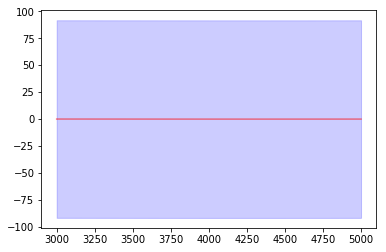

In [20]:
pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [21]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -22854.75


In [ ]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

In [ ]:
np.sqrt(np.exp(gp.get_parameter_vector())) # check lengthscales from hyperparameter values

In [ ]:
pred, pred_var = gp.predict(y, sl, return_var=True)

plt.fill_between(np.array(sl)[:,0], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,0], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
X, y = load_pcwpar(1)
yerr=[x*0.01 for x in y]

In [ ]:
kernel = kernels.ExpSquaredKernel(900**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(0.4**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

In [ ]:
sl=[]
for i in range(11):
    x=[steps[0][5],steps[1][i]]
    for j in range(len(ranges)-2):
        x.append(steps[j+2][5])
    sl.append(x)

pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)

In [ ]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [ ]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

t0=time()

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

print("done in %0.3fs" % (time() - t0))

In [ ]:
sl=[]
for i in range(11):
    x=[steps[0][5],steps[1][i]]
    for j in range(len(ranges)-2):
        x.append(steps[j+2][5])
    sl.append(x)

pred, pred_var = gp.predict(y, sl, return_var=True)
plt.fill_between(np.array(sl)[:,1], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(np.array(sl)[:,1], pred, "r", lw=1.5, alpha=0.5)